In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("ZZZtong/common-accent-vgg-ready")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/616 [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/262M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/262M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2538 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/308 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/309 [00:00<?, ? examples/s]

## vggish model

In [ ]:
# 1) Install & clone VGGish code + weights
!pip install tensorflow-hub librosa soundfile
!git clone --depth 1 https://github.com/tensorflow/models.git
%cd models/research/audioset/vggish
!wget https://storage.googleapis.com/audioset/vggish_model.ckpt
!wget https://storage.googleapis.com/audioset/vggish_pca_params.npz


Cloning into 'models'...
remote: Enumerating objects: 4327, done.
remote: Counting objects: 100% (4327/4327), done.
remote: Compressing objects: 100% (3345/3345), done.
remote: Total 4327 (delta 1208), reused 2051 (delta 910), pack-reused 0 (from 0)
Receiving objects: 100% (4327/4327), 53.65 MiB | 41.97 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.
/content/models/research/audioset/vggish
--2025-04-23 03:01:19--  https://storage.googleapis.com/audioset/vggish_model.ckpt
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.145.207, 142.250.125.207, 142.251.183.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.145.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 291108469 (278M) [application/octet-stream]
Saving to: ‘vggish_model.ckpt’

vggish_model.ckpt   100%[===================>] 277.62M   148MB/s    in 1.9s    

2025-04-23 03:01:21 (148 MB/s) - ‘vggish_model.ckpt’ saved [291108469/291108469]

--2025-04-2

In [ ]:
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 28.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Login using e.g. `huggingface-cli login` to access this dataset
splits = {'train': 'data/train-00000-of-00001.parquet', 'validation': 'data/validation-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/ZZZtong/common-accent-YAMnet/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/ZZZtong/common-accent-YAMnet/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/ZZZtong/common-accent-YAMnet/" + splits["test"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())


TF version: 2.18.0
Eager mode: True


In [ ]:
!pip install tensorflow tensorflow-hub soundfile


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import soundfile as sf
import numpy as np
from io import BytesIO
import time

VGGISH_URL = "https://tfhub.dev/google/vggish/1"
vggish = hub.load(VGGISH_URL)   # this is a pure Python callable in eager mode


### Original Preprocessing

In [ ]:
def wavbytes_to_vggish(wav_bytes: bytes) -> np.ndarray:
    # 1) Decode WAV bytes to (samples, ) float32 @ original sr
    data, sr = sf.read(BytesIO(wav_bytes), dtype='float32')
    # 2) Resample to 16 kHz if needed
    if sr != 16000:
        data = tf.signal.resample(data, int(len(data) * 16000 / sr)).numpy()
    # 3) Call vggish: returns a tf.Tensor shape (N_frames, 128)
    embeds = vggish(data)
    # 4) Convert to NumPy and average over frames → (128,)
    return embeds.numpy().mean(axis=0)

# 1) Create label → ID map
label_list = sorted(df_train['accent'].unique())
label2id   = {lab:i for i, lab in enumerate(label_list)}
for df in (df_train, df_val, df_test):
    df['label_id'] = df['accent'].map(label2id)

# 2) Loop to build X,y
def build_X_y(df):
    X = [wavbytes_to_vggish(x['bytes']) for x in df['audio']]
    y = df['label_id'].to_numpy()
    return np.stack(X, axis=0), y

start = time.time()
X_train, y_train = build_X_y(df_train)
X_val,   y_val   = build_X_y(df_val)
X_test,  y_test  = build_X_y(df_test)
end = time.time()

n = len(df_train)
total_original = end - start
print(f"Processed full train/val/test in {total_original :.2f} s "
      f"(avg {total_original/n:.4f} s per train-example)")

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

Processed full train/val/test in 8.60 s (avg 0.0034 s per train-example)
Shapes: (2538, 128) (308, 128) (309, 128)


### Numba Version


In [ ]:
import time
import numpy as np
import soundfile as sf
import tensorflow as tf
from io import BytesIO
from numba import njit, prange

# ── 1) Numba‑accelerated resampler ──
@njit(parallel=False)
def resample_numba(x: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
    ratio = target_sr / orig_sr
    out_len = int(x.shape[0] * ratio)
    y = np.empty(out_len, dtype=np.float32)
    for i in prange(out_len):
        pos = i / ratio
        left = int(pos)
        right = min(left + 1, x.shape[0] - 1)
        w = pos - left
        y[i] = x[left] * (1 - w) + x[right] * w
    return y

# ── 2) Optimized embedding function ──
def wavbytes_to_vggish_numba(wav_bytes: bytes) -> np.ndarray:
    # decode
    data, sr = sf.read(BytesIO(wav_bytes), dtype='float32')
    # fast resample if needed
    if sr != 16000:
        data = resample_numba(data, sr, 16000)
    # embed + average
    embeds = vggish(data)            # tf.Tensor [N_frames,128]
    return embeds.numpy().mean(axis=0)  # → (128,)



# ── 3) Prepare label mapping ──
label_list = sorted(df_train['accent'].unique())
label2id   = {lab: i for i, lab in enumerate(label_list)}
for df in (df_train, df_val, df_test):
    df['label_id'] = df['accent'].map(label2id)

# ── 4) Build X,y with timing ──
def build_X_y_numba(df):
    X = [wavbytes_to_vggish_numba(rec['bytes']) for rec in df['audio']]
    y = df['label_id'].to_numpy()
    return np.stack(X, axis=0), y

start = time.time()
X_train_opt, y_train   = build_X_y_numba(df_train)
X_val_opt,   y_val     = build_X_y_numba(df_val)
X_test_opt,  y_test    = build_X_y_numba(df_test)
end = time.time()

n = len(df_train)
total_numba = end - start
print(f"Processed full train/val/test in {total_numba:.2f} s "
      f"(avg {total_numba/n:.4f} s per train-example)")
print("Shapes:", X_train_opt.shape, X_val_opt.shape, X_test_opt.shape)


Processed full train/val/test in 8.55 s (avg 0.0034 s per train-example)
Shapes: (2538, 128) (308, 128) (309, 128)


### Multi-threads

In [ ]:
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import soundfile as sf
from io import BytesIO
import tensorflow as tf
from numba import njit, prange

# ─── re‑use your Numba resampler ───
@njit(parallel=True)
def resample_numba(x: np.ndarray, orig_sr: int, target_sr: int) -> np.ndarray:
    ratio = target_sr / orig_sr
    out_len = int(x.shape[0] * ratio)
    y = np.empty(out_len, dtype=np.float32)
    for i in prange(out_len):
        pos = i / ratio
        l = int(pos)
        r = min(l+1, x.shape[0]-1)
        w = pos - l
        y[i] = x[l] * (1-w) + x[r] * w
    return y

# ─── your optimized embed fn ───
def wavbytes_to_vggish_numba(wav_bytes: bytes) -> np.ndarray:
    data, sr = sf.read(BytesIO(wav_bytes), dtype='float32')
    if sr != 16000:
        data = resample_numba(data, sr, 16000)
    embeds = vggish(data)
    return embeds.numpy().mean(axis=0)

# ─── parallel builder with timing ───
def build_X_y_threaded(df, max_workers=8, fn=wavbytes_to_vggish_numba):
    """Build X,y by mapping fn over df['audio'] in parallel threads."""
    wav_list = [rec['bytes'] for rec in df['audio']]
    y = df['label_id'].to_numpy()

    t0 = time.time()
    with ThreadPoolExecutor(max_workers=max_workers) as exe:
        X_list = list(exe.map(fn, wav_list))
    t1 = time.time()

    X = np.stack(X_list, axis=0)
    print(f"Processed {len(wav_list)} samples in {t1-t0:.2f}s "
          f"(avg {(t1-t0)/len(wav_list):.4f}s each) "
          f"with {max_workers} threads.")
    return X, y

# ─── prepare labels ───
label_list = sorted(df_train['accent'].unique())
label2id   = {lab:i for i,lab in enumerate(label_list)}
for d in (df_train, df_val, df_test):
    d['label_id'] = d['accent'].map(label2id)

# ─── run it ───
start = time.time()
X_train, y_train = build_X_y_threaded(df_train, max_workers=8)
X_val,   y_val   = build_X_y_threaded(df_val,   max_workers=8)
X_test,  y_test  = build_X_y_threaded(df_test,  max_workers=8)
end = time.time()


n = len(df_train)
total_parallel = end - start
print(f"Processed full train/val/test in {total_parallel :.2f} s "
      f"(avg {total_parallel /n:.4f} s per train-example)")
print("Final shapes:", X_train.shape, X_val.shape, X_test.shape)


Processed 2538 samples in 4.59s (avg 0.0018s each) with 8 threads.
Processed 308 samples in 0.56s (avg 0.0018s each) with 8 threads.
Processed 309 samples in 0.56s (avg 0.0018s each) with 8 threads.
Processed full train/val/test in 5.72 s (avg 0.0023 s per train-example)
Final shapes: (2538, 128) (308, 128) (309, 128)


### Optimization Visualization

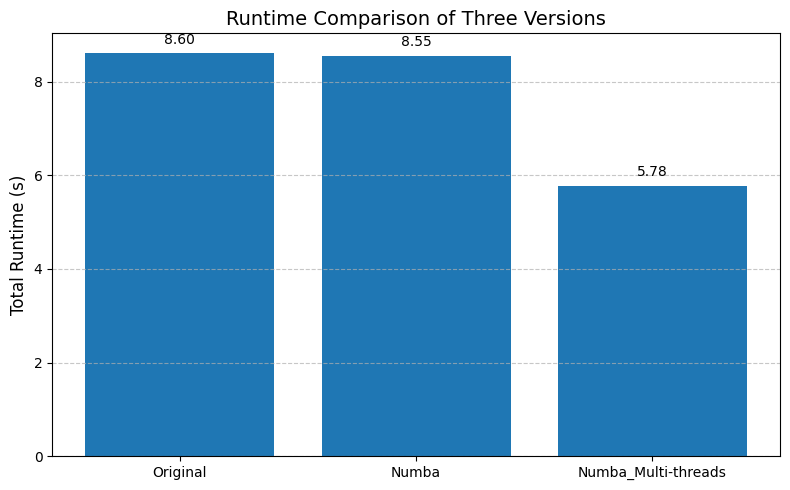

In [ ]:
import matplotlib.pyplot as plt

# Example data placeholders; replace with your measured values
versions = ['Original', 'Numba', 'Numba_Multi-threads']
total_runtimes = [total_original, total_numba, total_parallel]  # in seconds

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Draw bars
bars = ax.bar(versions, total_runtimes)

# Add labels and title
ax.set_ylabel("Total Runtime (s)", fontsize=12)
ax.set_title("Runtime Comparison of Three Versions", fontsize=14)

# Add a horizontal grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its value
for bar in bars:
    height = bar.get_height()
    ax.annotate(
        f"{height:.2f}",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5), textcoords="offset points",
        ha='center', va='bottom', fontsize=10
    )

plt.tight_layout()
plt.show()


### Model Running

In [ ]:
import time
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Original model definition ---
inputs = layers.Input(shape=(128,))
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
out = layers.Dense(len(label_list), activation="softmax")(x)

model = models.Model(inputs, out)
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# --- Measure training time ---
start_train = time.time()
model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)
end_train = time.time()
print(f"Training time: {end_train - start_train:.2f} s")

# --- Measure evaluation time and accuracy ---
start_eval = time.time()
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=32)
end_eval = time.time()
print(f"Test accuracy: {test_acc:.4f}")
print(f"Evaluation time: {end_eval - start_eval:.2f} s")


Epoch 1/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.3795 - loss: 1.5671 - val_accuracy: 0.4740 - val_loss: 1.2751
Epoch 2/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 1.2219 - val_accuracy: 0.5097 - val_loss: 1.1901
Epoch 3/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5520 - loss: 1.1595 - val_accuracy: 0.5195 - val_loss: 1.1374
Epoch 4/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5908 - loss: 1.1074 - val_accuracy: 0.5682 - val_loss: 1.1226
Epoch 5/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5915 - loss: 1.0806 - val_accuracy: 0.5844 - val_loss: 1.0815
Epoch 6/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5879 - loss: 1.0537 - val_accuracy: 0.5844 - val_loss: 1.0468
Epoch 7/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6254 - loss: 0.9964 - val_accuracy: 0.6071 - val_loss: 1.0362
Epoch 8/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5983 - loss: 1.0063 - val_accuracy: 0.5942 - val_loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras import mixed_precision

# 0) Mixed precision on GPUs
mixed_precision.set_global_policy('mixed_float16')

# 1) Build a tf.data pipeline
def make_ds(X, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=10_000)
    return ds.batch(64).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_train, y_train, shuffle=True)
val_ds   = make_ds(X_val,   y_val)
test_ds  = make_ds(X_test,  y_test)

# 2) Model definition (same)
inputs = layers.Input(shape=(128,))
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dropout(0.5)(x)
out = layers.Dense(len(label_list), activation="softmax", dtype="float32")(x)
# note dtype="float32" here to cast logits back to float32 for the loss

model = models.Model(inputs, out)



opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    jit_compile=True
)

start = time.time()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=80,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
    ],
    verbose=0
)
print("Optimized training time:", time.time() - start)


# 6) Evaluate
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


Optimized training time: 8.510178327560425
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.6286 - loss: 0.9749
Test accuracy: 0.6181229948997498


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, losses, callbacks
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts

# 1) Build a deeper, better‑regularized head (on your frozen 128‑D embeddings)
inputs = layers.Input(shape=(128,), name="vggish_embed")

x = layers.Dense(512, kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(256, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(len(label_list), activation="softmax")(x)

model = models.Model(inputs, outputs)

# 2) Cosine‑Decay‑Restarts schedule
initial_lr = 1e-3
# You may want first_decay_steps = steps_per_epoch * 5 or similar
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=1000,  # adjust to your dataset size
    t_mul=2.0,
    m_mul=1.0
)

opt = AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)

loss_fn = losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=opt,
    loss=loss_fn,
    metrics=["accuracy"]
)

model.summary()

# 3) Train with EarlyStopping only
history = model.fit(
    X_train,
    tf.keras.utils.to_categorical(y_train, len(label_list)),
    validation_data=(X_val, tf.keras.utils.to_categorical(y_val, len(label_list))),
    epochs=80,
    batch_size=32,
    callbacks=[
        callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

# 4) Evaluate
test_loss, test_acc = model.evaluate(
    X_test,
    tf.keras.utils.to_categorical(y_test, len(label_list)),
    batch_size=32
)
print(f"Test accuracy: {test_acc:.4f}")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vggish_embed (InputLayer)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_7 (Cast)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,990 (789.02 KB)

 Trainable params: 200,454 (783.02 KB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.3685 - loss: 1.9788 - val_accuracy: 0.4838 - val_loss: 1.5821
Epoch 2/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4948 - loss: 1.5364 - val_accuracy: 0.5162 - val_loss: 1.4757
Epoch 3/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5422 - loss: 1.4437 - val_accuracy: 0.5487 - val_loss: 1.3686
Epoch 4/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5690 - loss: 1.3742 - val_accuracy: 0.5877 - val_loss: 1.3005
Epoch 5/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5882 - loss: 1.3349 - val_accuracy: 0.6039 - val_loss: 1.2523
Epoch 6/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5886 - loss: 1.2982 - val_accuracy: 0.5909 - val_loss: 1.2287
Epoch 7/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6138 - loss: 1.2581 - val_accuracy: 0.6039 - val_loss: 1.2083
Epoch 8/80
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6202 - loss: 1.2560 - val_accuracy: 0.6331 - val_loss

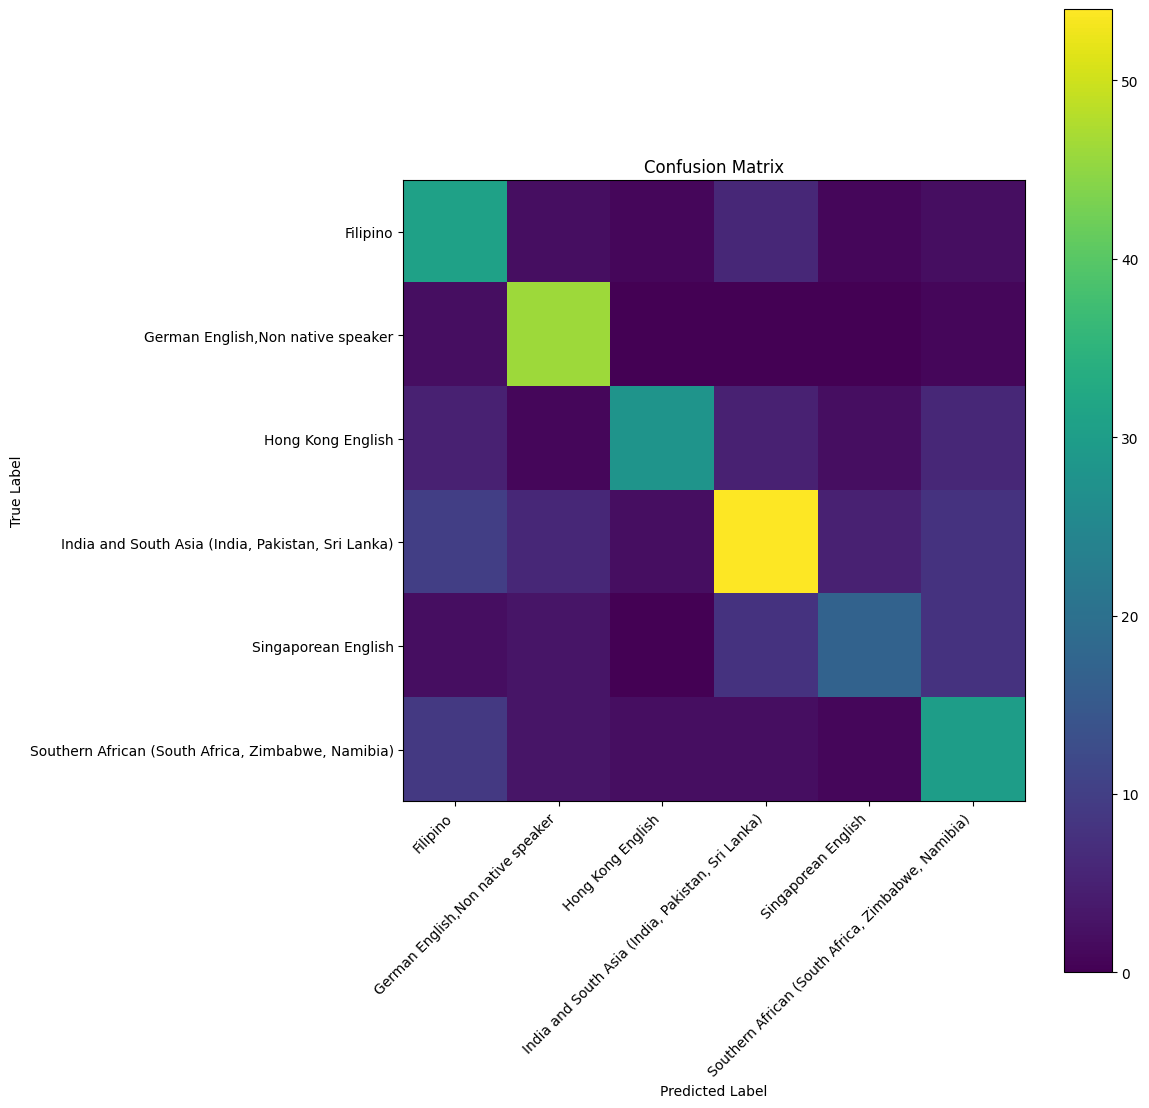

Classification Report:

                                                    precision    recall  f1-score   support

                                          Filipino     0.5254    0.7209    0.6078        43
                 German English,Non native speaker     0.7541    0.9388    0.8364        49
                                 Hong Kong English     0.8485    0.5957    0.7000        47
 India and South Asia (India, Pakistan, Sri Lanka)     0.7200    0.6353    0.6750        85
                               Singaporean English     0.6538    0.4474    0.5312        38
Southern African (South Africa, Zimbabwe, Namibia)     0.5455    0.6383    0.5882        47

                                          accuracy                         0.6667       309
                                         macro avg     0.6746    0.6627    0.6564       309
                                      weighted avg     0.6832    0.6667    0.6642       309



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

# Compute predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(12, 12))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(np.arange(len(label_list)), label_list, rotation=45, ha='right')
plt.yticks(np.arange(len(label_list)), label_list)
plt.colorbar()
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_test, y_pred, target_names=label_list, digits=4)
print("Classification Report:\n")
print(report)
